# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [4]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import os

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2023 from the CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [6]:
year = "2023"
years = [2023]

# Ensure the directory exists
os.makedirs(f"models/{year}", exist_ok=True)

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 286481


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [8]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
146147,20230706235605PD,9618624,7/6/2023 12:00:00 AM,P231870987,6,7/6/2023 12:00:00 AM,7/6/2023 12:00:00 AM,23:54:57,1195,VEHICLE STOP,N,No report required; dispatch record only,HILLSDALE AV & WOODMERE DR,San Jose,CA,37.273021,-121.882425,Valley View Reed
95512,20230507012355PD,9539480,5/6/2023 12:00:00 AM,P231261143,2,5/6/2023 12:00:00 AM,5/6/2023 12:00:00 AM,23:33:17,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch record only,[2700]-[2800] KOLLMAR DR,San Jose,CA,37.350906,-121.825271,Kolmar and Ryan
90289,20230429221457PD,9530744,4/29/2023 12:00:00 AM,P231190869,6,4/29/2023 12:00:00 AM,4/29/2023 12:00:00 AM,21:54:10,1195,VEHICLE STOP,N,No report required; dispatch record only,S 22ND ST & E SAN ANTONIO ST,San Jose,CA,37.348097,-121.856190,Pink Elephant and PAL
20866,20230128153703PS,9417314,1/28/2023 12:00:00 AM,P230280468,4,1/28/2023 12:00:00 AM,1/28/2023 12:00:00 AM,14:19:05,22500,PARKING VIOLATION,E,"Traffic Citation Issued, Non-Hazardous Violation",[0]-[100] MARGARET ST,San Jose,CA,37.330058,-121.873198,South University
75409,20230410141319PD,9506716,4/10/2023 12:00:00 AM,P231000582,6,4/10/2023 12:00:00 AM,4/10/2023 12:00:00 AM,14:06:33,1195,VEHICLE STOP,N,No report required; dispatch record only,FOXWORTHY AV & ARROBA WY,San Jose,CA,37.270625,-121.903328,Kirk


In [9]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286481 entries, 0 to 286480
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              286481 non-null  object 
 1   EID               286481 non-null  int64  
 2   START_DATE        286481 non-null  object 
 3   CALL_NUMBER       286481 non-null  object 
 4   PRIORITY          286481 non-null  int64  
 5   REPORT_DATE       286481 non-null  object 
 6   OFFENSE_DATE      286481 non-null  object 
 7   OFFENSE_TIME      286481 non-null  object 
 8   CALLTYPE_CODE     286481 non-null  object 
 9   CALL_TYPE         286481 non-null  object 
 10  FINAL_DISPO_CODE  286481 non-null  object 
 11  FINAL_DISPO       286481 non-null  object 
 12  ADDRESS           278673 non-null  object 
 13  CITY              286481 non-null  object 
 14  STATE             286481 non-null  object 
 15  LATITUDE          256293 non-null  float64
 16  LONGITUDE         25

In [10]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,2.864810e+05,286481.000000,256293.000000,256293.000000
mean,9.613875e+06,3.181171,37.322032,-121.872499
std,1.324880e+05,1.338284,0.042839,0.047605
min,9.383083e+06,1.000000,37.150332,-122.035696
25%,9.500198e+06,2.000000,37.297632,-121.903908
50%,9.613307e+06,3.000000,37.325114,-121.870243
75%,9.728012e+06,4.000000,37.349527,-121.840346
max,9.844602e+06,6.000000,37.534539,-121.660052


In [11]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,286481,286481,286481,286481,286481,286481,286481,286481,286481,286481,278673,286481,286481,255093
unique,284708,351,278955,365,365,80430,203,199,22,18,29211,1,1,295
top,20230422190431PD,5/29/2023 12:00:00 AM,P230100644,5/6/2023 12:00:00 AM,5/6/2023 12:00:00 AM,19:37:12,1195,VEHICLE STOP,N,No report required; dispatch record only,[2800]-[2900] STEVENS CREEK BL,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,4873,7,1009,1009,15,26873,26873,130397,130397,1475,286481,286481,8126


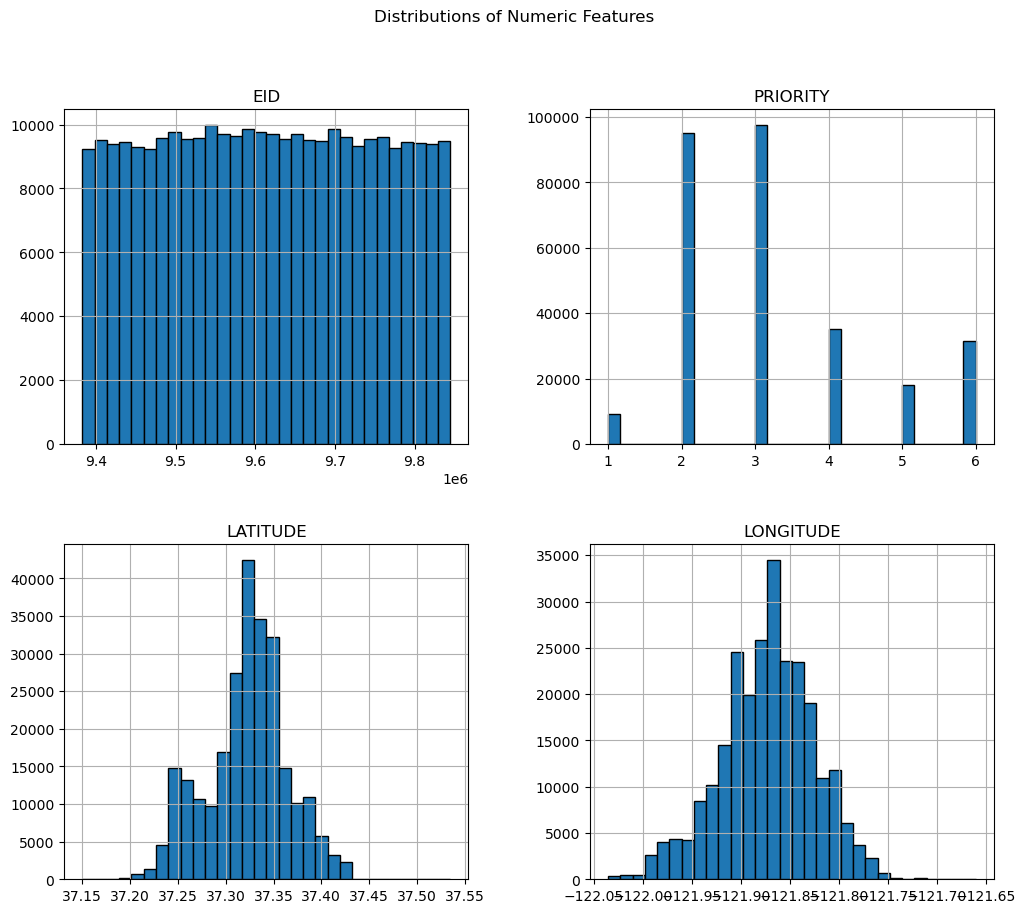

In [13]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [14]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              7808
CITY                    0
STATE                   0
LATITUDE            30188
LONGITUDE           30188
neighborhood        31388
dtype: int64

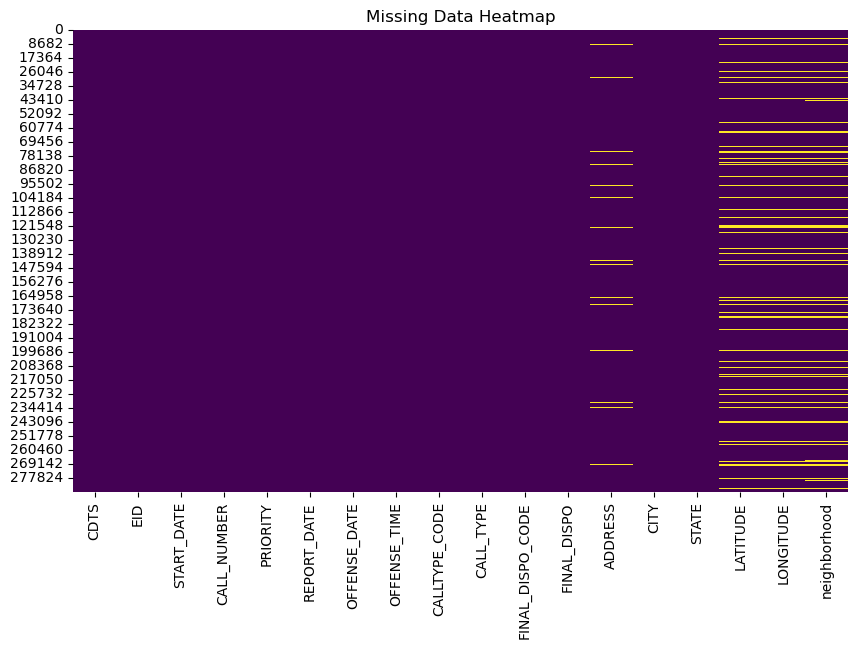

In [15]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [18]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 284708 unique values
START_DATE: 351 unique values
CALL_NUMBER: 278955 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 80430 unique values
CALLTYPE_CODE: 203 unique values
CALL_TYPE: 199 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 29211 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [21]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8126
Little Saigon and Spring Brook    4803
Trimble Business Area             4419
Five Wounds-San Jose High         4303
Steinbeck and Allen               3856
                                  ... 
Santa Teresa Hills                  38
Meadowlands                         37
Hamann Park                         34
Linda Vista and Hillcrest           32
Alta Vista                          21
Name: count, Length: 295, dtype: int64

In [22]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          130397
CAN         57328
R           36122
G           13904
O            6130
GD           5745
DUPNCAN      5403
E            4647
A            4558
D            4433
U            4050
H            3413
T            2961
ADV          2137
C            1933
B            1594
NR           1129
F             486
Z              42
M              36
P              25
TOT             8
Name: count, dtype: int64

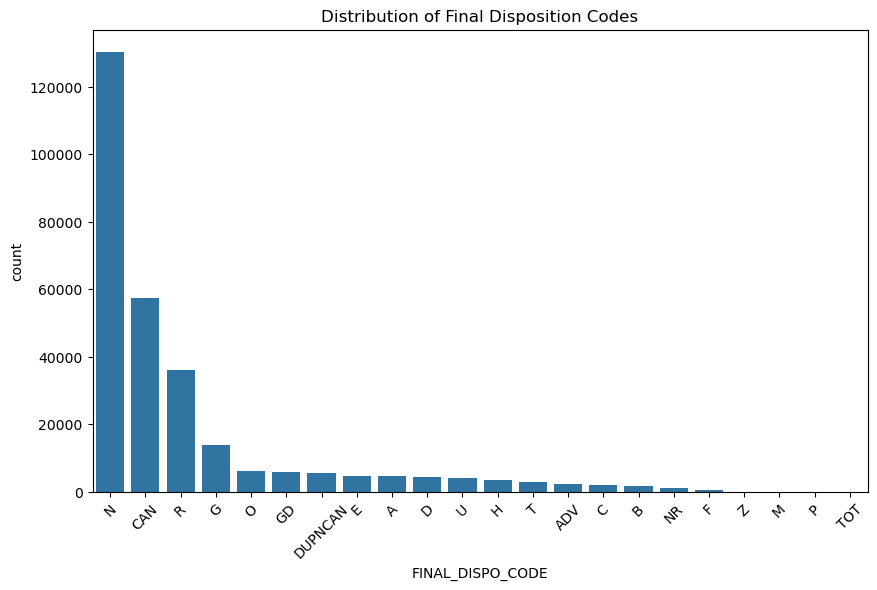

In [24]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [25]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch record only            130397
Canceled                                             57328
Report taken                                         36122
Gone on Arrival/unable to locate                     13904
No Disposition                                       13335
Supplemental report taken                             6130
Traffic Citation Issued, Non-Hazardous Violation      4647
Arrest Made                                           4558
Traffic Citation Issued, Hazardous Violation          4433
Unfounded event                                       4050
Courtesy Service/Citizen or agency assist             3413
Turned over To (TOT)                                  2961
Criminal Citation                                     1933
Arrest by Warrant                                     1594
No Response                                           1129
Field Interview (F.I.) Completed                       486
Stranded motorist assist                    

In [27]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'GD': 'No Disposition',
 'CAN': 'Canceled',
 'N': 'No report required; dispatch record only',
 'G': 'Gone on Arrival/unable to locate',
 'R': 'Report taken',
 'O': 'Supplemental report taken',
 'NR': 'No Response',
 'C': 'Criminal Citation',
 'DUPNCAN': 'No Disposition',
 'E': 'Traffic Citation Issued, Non-Hazardous Violation',
 'U': 'Unfounded event',
 'T': 'Turned over To (TOT)',
 'B': 'Arrest by Warrant',
 'D': 'Traffic Citation Issued, Hazardous Violation',
 'A': 'Arrest Made',
 'H': 'Courtesy Service/Citizen or agency assist',
 'ADV': 'No Disposition',
 'Z': 'No Disposition',
 'F': 'Field Interview (F.I.) Completed',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity only',
 'TOT': 'No Disposition'}

In [29]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 '1033A': 'ALARM, AUDIBLE',
 '459R': 'BURGLARY  REPORT  (460)',
 'AID': 'PUBLIC SAFETY ASSISTANCE',
 '1125': 'TRAFFIC HAZARD',
 '415': 'DISTURBANCE',
 '415F': 'DISTURBANCE, FAMILY',
 '602PC': 'TRESPASSING',
 '22500': 'PARKING VIOLATION',
 '1195': 'VEHICLE STOP',
 '484': 'THEFT',
 '10851': 'STOLEN VEHICLE',
 'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAMAGE',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '23103': 'RECKLESS DRIVING',
 '1154': 'SUSPICIOUS VEHICLE',
 '5150': 'MENTALLY DISTURBED PERSON',
 '1095': 'PEDESTRIAN STOP',
 'WELCK': 'WELFARE CHECK',
 '487': 'GRAND THEFT',
 '245': 'ASSAULT WITH DEADLY WEAPON',
 '5150X': 'MENTALLY DISTURBED FEMALE',
 '415M': 'DISTURBANCE, MUSIC',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '911UNK': 'UNK TYPE 911 CALL',
 '1066': 'SUSPICIOUS PERSON',
 '1184': 'TRAFFIC CONTROL',
 '594': 'MALICIOUS MISCHIEF',
 '415W': 'DISTURBANCE, WEAPON',
 '422': 'CRIMINAL THREATS',
 '242EMS': 'BA

## Focus on Target Dispositions

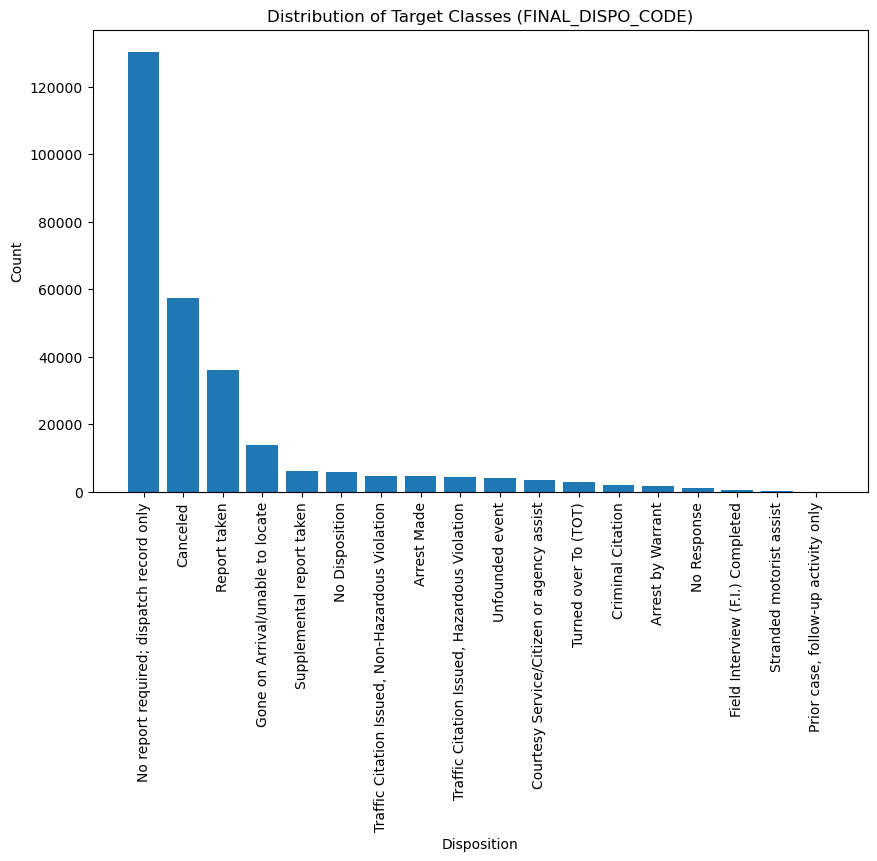

In [31]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [32]:
model_utils.transform_offense_date(all_police_df)

In [33]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    278396
A          4558
C          1933
B          1594
Name: count, dtype: int64

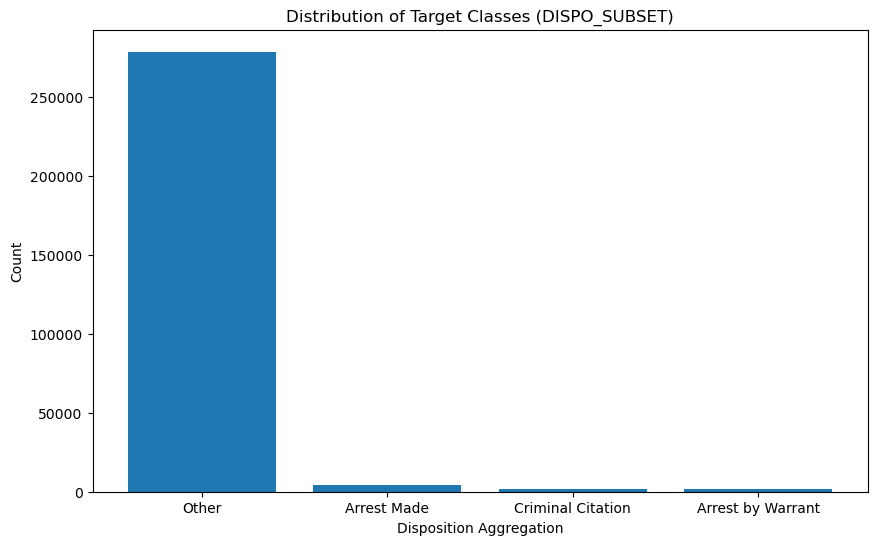

In [34]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [36]:
encoder = joblib.load('one_hot_encoder.pkl')

In [37]:
police_calls_encoded, _ = model_utils.clean_and_transform_data(all_police_df, encoder)
police_calls_encoded.shape

Police Calls Dataset: 286481 rows before cleaning, 255093 rows after cleaning.


(255093, 535)

## Define X and Y

In [40]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(204074, 534)
(51019, 534)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 198248, 0: 3317, 2: 1347, 1: 1162})
Counter({3: 5826, 0: 3317, 2: 1347, 1: 1162})


y_train distribution: Counter({3: 198248, 0: 3317, 2: 1347, 1: 1162})
y_test distribution: Counter({3: 49562, 0: 829, 2: 337, 1: 291})
y_train_resampled distribution: Counter({3: 198248, 0: 3317, 2: 1347, 1: 1162})


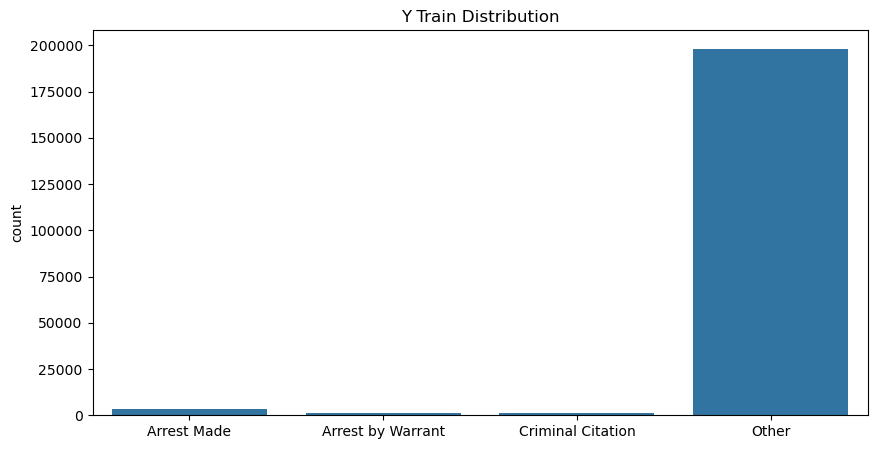

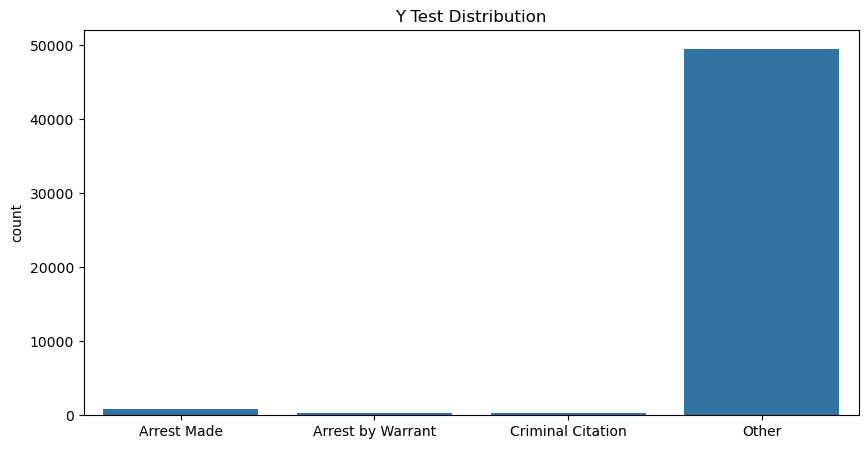

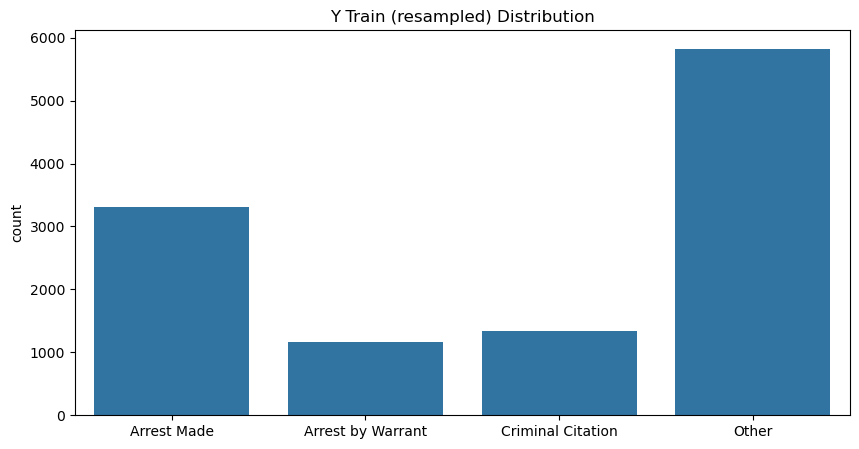

In [41]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [51]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [55]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [58]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00       829
Arrest by Warrant       0.00      0.00      0.00       291
Criminal Citation       0.00      0.00      0.00       337
            Other       0.97      1.00      0.99     49562

         accuracy                           0.97     51019
        macro avg       0.24      0.25      0.25     51019
     weighted avg       0.94      0.97      0.96     51019



### Logistic Regression

In [60]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [61]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [62]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.11      0.63      0.18       829
Arrest by Warrant       0.23      0.42      0.29       291
Criminal Citation       0.09      0.48      0.15       337
            Other       0.99      0.87      0.93     49562

         accuracy                           0.86     51019
        macro avg       0.35      0.60      0.39     51019
     weighted avg       0.97      0.86      0.91     51019



#### Hyperparameter Tuning

In [64]:
grid_search_scoring_method = 'f1_macro'

In [66]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Initialize Grid Search
# make sure n_jobs is reasonable so my machine doesn't run out of memory
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=3, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=3, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [67]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 1}
Best Score (f1_macro): 0.4907


In [68]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2023/best_logistic_regression.pkl']

In [69]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [70]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.60      0.21      0.31       829
Arrest by Warrant       0.57      0.39      0.47       291
Criminal Citation       0.48      0.13      0.20       337
            Other       0.98      1.00      0.99     49562

         accuracy                           0.97     51019
        macro avg       0.66      0.43      0.49     51019
     weighted avg       0.97      0.97      0.97     51019



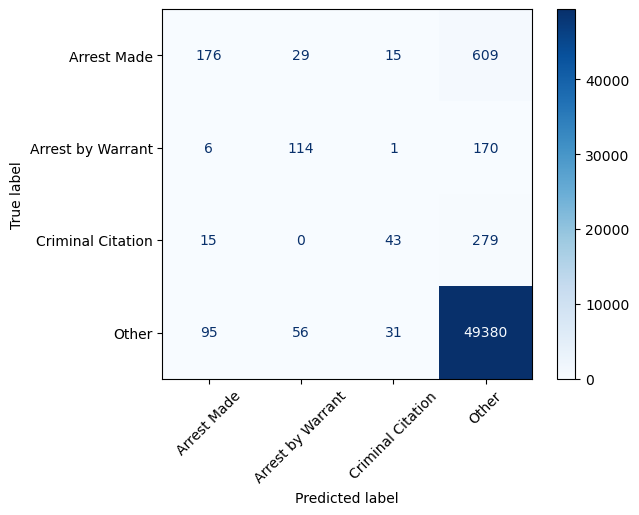

In [71]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [73]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [74]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [75]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                       Feature  Importance  \
112                        CALLTYPE_CODE_23152    0.002352   
204                           CALLTYPE_CODE_6F    0.001960   
205                           CALLTYPE_CODE_6M    0.001274   
64                         CALLTYPE_CODE_11300    0.001274   
58                          CALLTYPE_CODE_1095    0.001078   
49                        CALLTYPE_CODE_10851R    0.000980   
69                         CALLTYPE_CODE_11377    0.000947   
119                          CALLTYPE_CODE_242    0.000751   
146                         CALLTYPE_CODE_415F    0.000686   
72                         CALLTYPE_CODE_11550    0.000686   
125                          CALLTYPE_CODE_245    0.000523   
85                         CALLTYPE_CODE_12020    0.000523   
170                          CALLTYPE_CODE_484    0.000490   
231                         CALLTYPE_CODE_DVRO    0.000457   
87                         CALLTYPE_CODE_12025    0.000425   
185     

In [77]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                        Display Name  Coefficient
13                         Call Type: ALARM, AUDIBLE    -0.407970
47                         Call Type: STOLEN VEHICLE     0.367439
153                    Call Type: DISTURBANCE, MUSIC    -0.363467
107                     Call Type: PARKING VIOLATION    -0.358588
49               Call Type: RECOVERED STOLEN VEHICLE     0.313577
232        Call Type: FIRE DEPARTMENT REQUEST FOR PD    -0.274512
231         Call Type: VIOLATION OF PROTECTIVE ORDER     0.228704
146                   Call Type: DISTURBANCE, FAMILY     0.226418
174                           Call Type: GRAND THEFT     0.214666
112                       Call Type: MISDEMEANOR DUI     0.212424
125            Call Type: ASSAULT WITH DEADLY WEAPON     0.200189
185                    Call Type: MALICIOUS MISCHIEF     0.189816
212                     Call Type: UNK TYPE 911 CALL    -0.182620
0                                           PRIORITY   

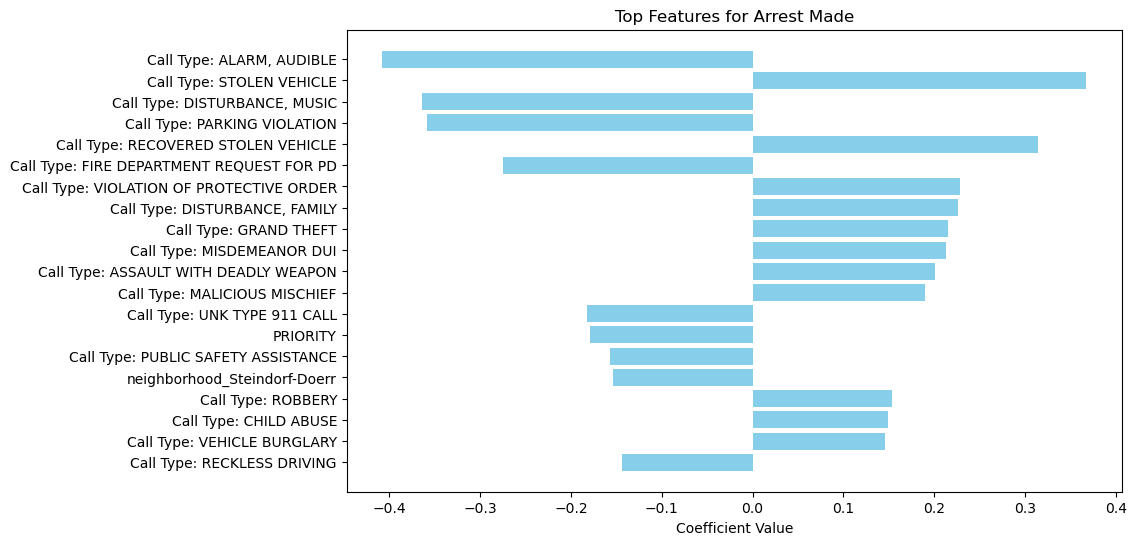

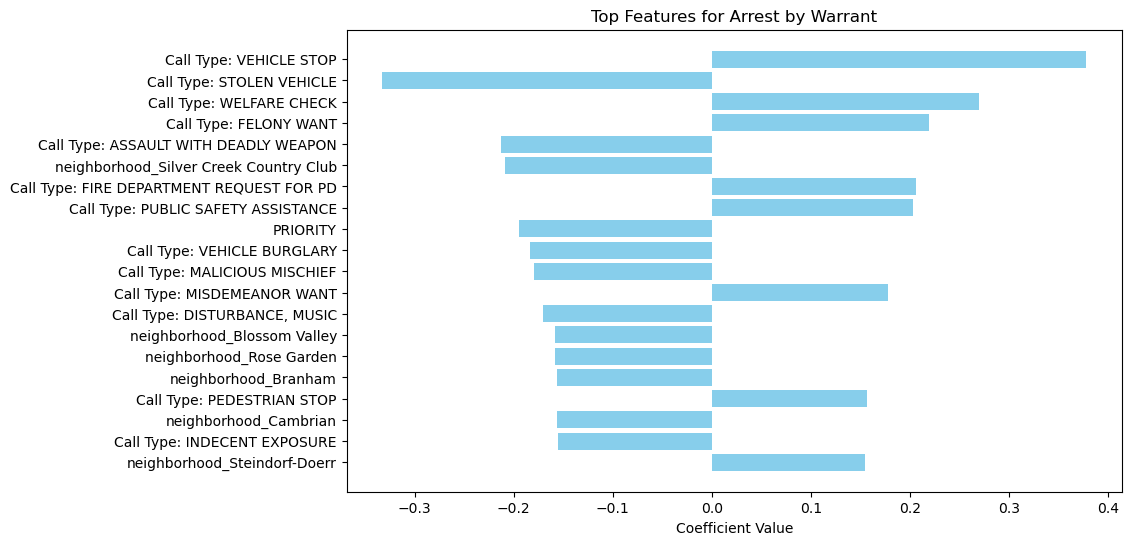

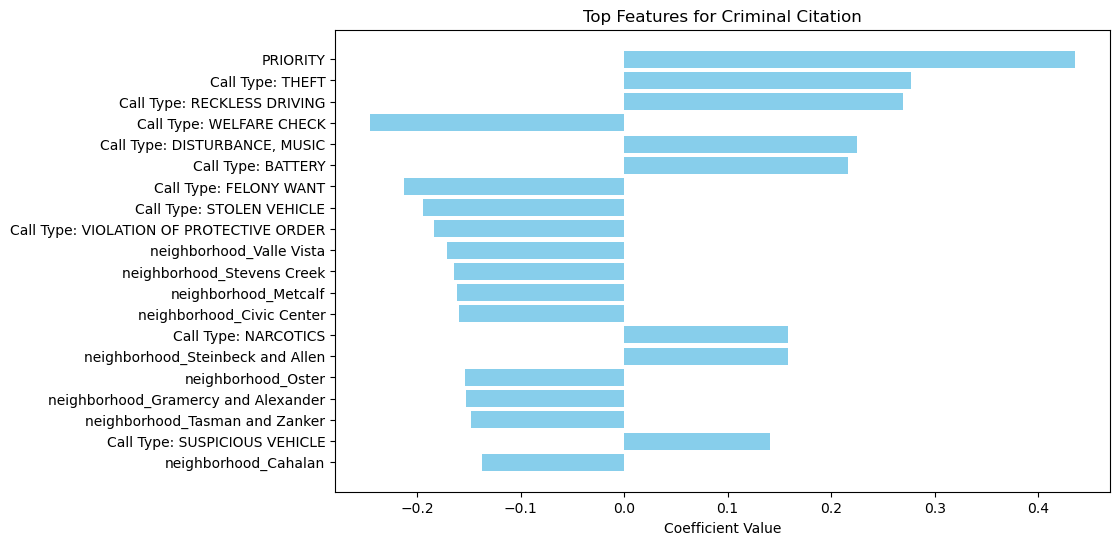

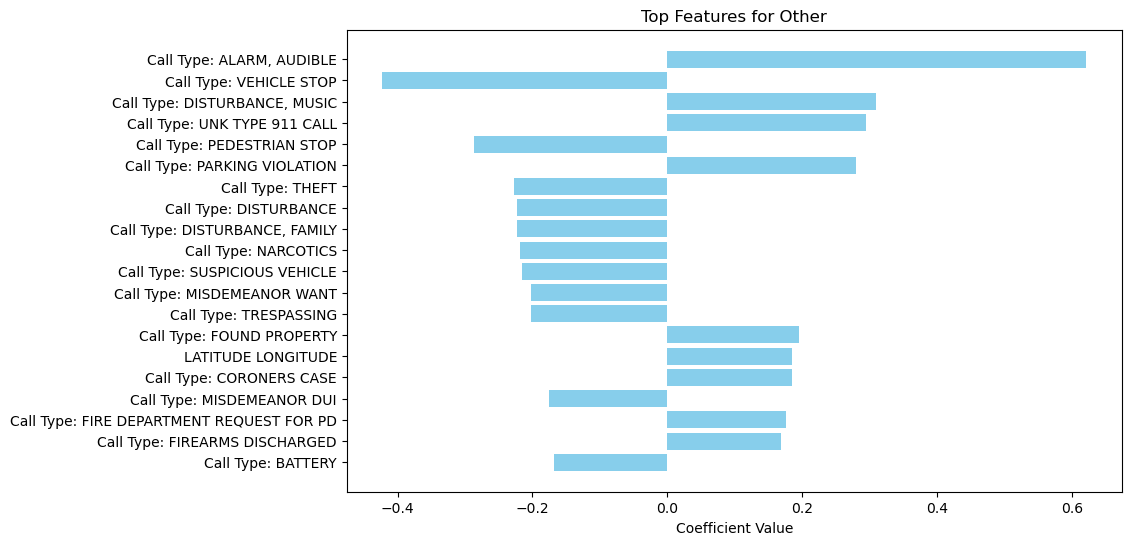

In [78]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [81]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [85]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.46      0.20      0.28       829
Arrest by Warrant       0.49      0.35      0.40       291
Criminal Citation       0.36      0.20      0.26       337
            Other       0.98      0.99      0.99     49562

         accuracy                           0.97     51019
        macro avg       0.57      0.43      0.48     51019
     weighted avg       0.96      0.97      0.97     51019



#### Hyperparameter Tuning and Cross Validation

In [87]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=5,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.47


In [88]:
best_rf = grid_rf.best_estimator_

In [89]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2023/best_random_forest.pkl']

In [90]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [91]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.47      0.19      0.27       829
Arrest by Warrant       0.47      0.34      0.39       291
Criminal Citation       0.34      0.17      0.23       337
            Other       0.98      0.99      0.99     49562

         accuracy                           0.97     51019
        macro avg       0.56      0.42      0.47     51019
     weighted avg       0.96      0.97      0.97     51019



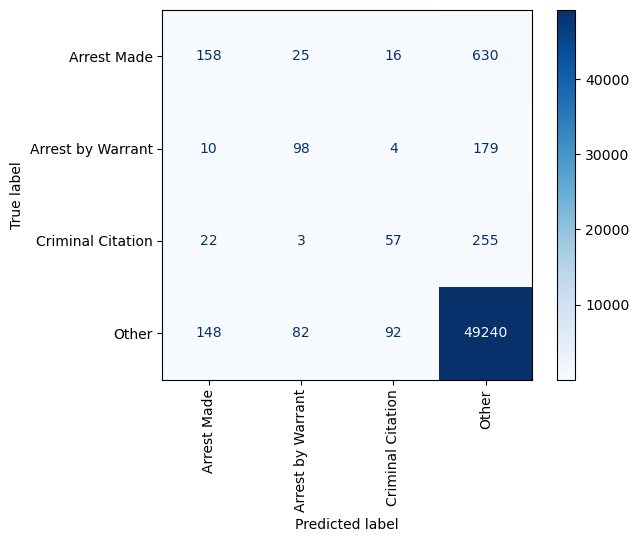

In [92]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

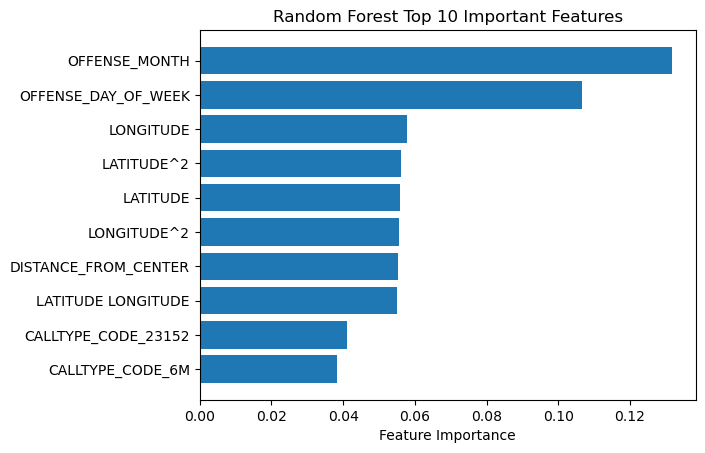

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Top 10 Important Features')
plt.show()

### Multilayer Perceptron Model

In [96]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [97]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [98]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [99]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9682 - loss: 0.1540 - val_accuracy: 0.9719 - val_loss: 0.1138
Epoch 2/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9732 - loss: 0.1126 - val_accuracy: 0.9722 - val_loss: 0.1126
Epoch 3/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9735 - loss: 0.1086 - val_accuracy: 0.9720 - val_loss: 0.1127
Epoch 4/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9745 - loss: 0.1015 - val_accuracy: 0.9727 - val_loss: 0.1115
Epoch 5/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9743 - loss: 0.0999 - val_accuracy: 0.9731 - val_loss: 0.1125
Epoch 6/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9739 - loss: 0.0989 - val_accuracy: 0.9730 - val_loss: 0.1133
Epoch 7/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9745 - loss: 0.0964 - val_accuracy: 0.9730 - val_loss: 0.1163
Epoch 8/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9748 - loss: 0.0941 - 

In [100]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2023/mlp_model.pkl']

In [101]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [102]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1595/1595 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.9740 - loss: 0.1139
Test Accuracy: 0.9742


In [103]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1595/1595 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.62      0.18      0.28       829
Arrest by Warrant       0.60      0.40      0.48       291
Criminal Citation       0.46      0.05      0.09       337
            Other       0.98      1.00      0.99     49562

         accuracy                           0.97     51019
        macro avg       0.67      0.41      0.46     51019
     weighted avg       0.97      0.97      0.97     51019



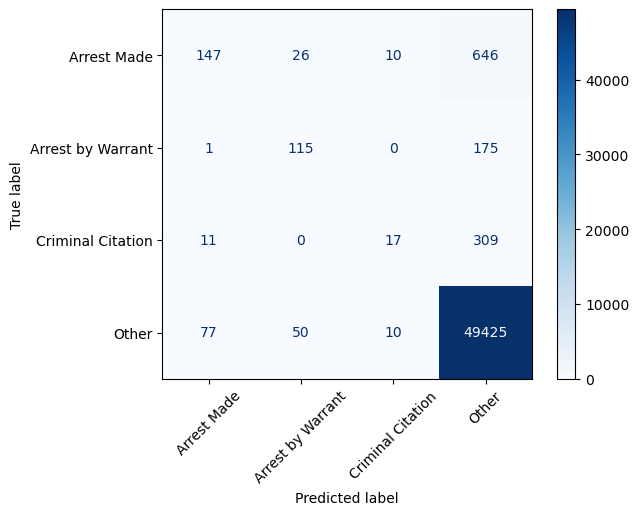

In [104]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [109]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-04 13:38:26,774] A new study created in memory with name: no-name-bb460bf4-a455-420a-8192-ec7207540881
[I 2024-10-04 13:38:56,042] Trial 0 finished with value: 0.5990710484354288 and parameters: {'n_estimators': 391, 'learning_rate': 0.006148953609680042, 'max_depth': 6, 'subsample': 0.9420869113926563, 'colsample_bytree': 0.7702604844843545, 'gamma': 9.500969548068193e-05, 'reg_alpha': 5.866504897845746e-07, 'reg_lambda': 0.005987956216420633}. Best is trial 0 with value: 0.5990710484354288.
[I 2024-10-04 13:39:15,706] Trial 1 finished with value: 0.5216387058183758 and parameters: {'n_estimators': 368, 'learning_rate': 0.0036430606543430026, 'max_depth': 3, 'subsample': 0.7372421799894365, 'colsample_bytree': 0.6092352597858665, 'gamma': 7.257588647324534e-08, 'reg_alpha': 2.9164422845960476e-07, 'reg_lambda': 3.356640785366316e-07}. Best is trial 0 with value: 0.5990710484354288.
[I 2024-10-04 13:39:25,783] Trial 2 finished with value: 0.5828258965353357 and parameters: {

Actual runtime: 483.07 seconds (8.05 minutes)
Best parameters found:  {'n_estimators': 300, 'learning_rate': 0.05111186674087545, 'max_depth': 7, 'subsample': 0.8558660345026208, 'colsample_bytree': 0.7664772583890618, 'gamma': 0.1519945207307289, 'reg_alpha': 0.0009844432145245726, 'reg_lambda': 1.0195646867329692e-08}
Best F1 macro score:  0.6302684535902157


In [112]:
# Train the final model with the best parameters:
best_params = study.best_params
best_model = XGBClassifier(**best_params, eval_metric='logloss')
best_model.fit(X_train, y_train)
xgb_1_model = best_model
xgb_1_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7664772583890618, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.1519945207307289, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05111186674087545,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [113]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.65      0.19      0.29       829
Arrest by Warrant       0.58      0.33      0.42       291
Criminal Citation       0.54      0.15      0.23       337
            Other       0.98      1.00      0.99     49562

         accuracy                           0.97     51019
        macro avg       0.69      0.42      0.48     51019
     weighted avg       0.97      0.97      0.97     51019



In [114]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2023/xgb_model.pkl']

In [115]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [117]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [118]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.4920791567594412
RF F1: 0.4687457984290337
XGB F1: 0.48380470309455403


In [119]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

#### Stacking #1

In [121]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=5)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7664772583890618,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              ev...
                                              learning_rate=0.05111186674087545,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(), n_jobs=5)

In [122]:
joblib.dump(stacking_clf, f"models/{year}/stacking_1.pkl") 

['models/2023/stacking_1.pkl']

In [123]:
stacking_clf = joblib.load(f"models/{year}/stacking_1.pkl")

In [124]:
y_pred_stacking_1 = stacking_clf.predict(X_test)
stack_1_accuracy = accuracy_score(y_test, y_pred_stacking_1)
stack_1_recall = recall_score(y_test, y_pred_stacking_1, average='macro')
stack_1_prec = precision_score(y_test, y_pred_stacking_1, average='macro')
stack_1_f1 = f1_score(y_test, y_pred_stacking_1, average='macro')
print(f"Stacking Classifier F1 Score: {stack_1_f1}")

Stacking Classifier F1 Score: 0.4943817938403835


#### Stacking #2

In [126]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=5)
stacking_clf_2.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7664772583890618,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              ev...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=5)

In [127]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2023/stacking_2.pkl']

In [128]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [129]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.5042005302406103


## Results

In [131]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Stack 1', 'Stack 2'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.971442,0.250000,0.242861,0.246379
Logistic Regression,0.974402,0.431995,0.658101,0.492079
Random Forest,0.971266,0.422501,0.563684,0.468746
MLP,0.974225,0.405048,0.665521,0.457872
XGB,0.974617,0.416462,0.687974,0.483805
Stack 1,0.974794,0.426118,0.666884,0.494382
Stack 2,0.974813,0.437381,0.667575,0.504201


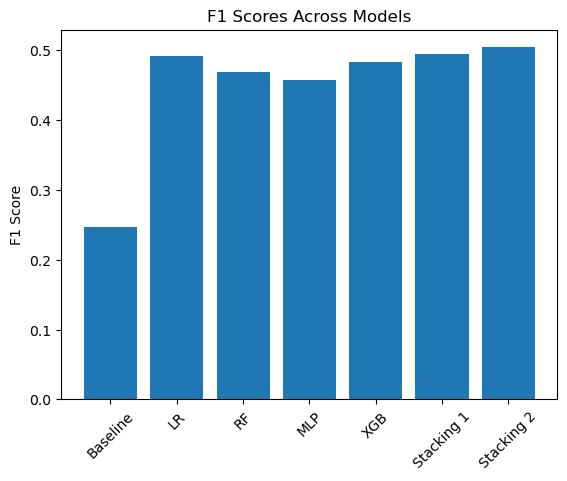

In [132]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Stacking 1', 'Stacking 2']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Compare with the All-Year Models

In [134]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [135]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

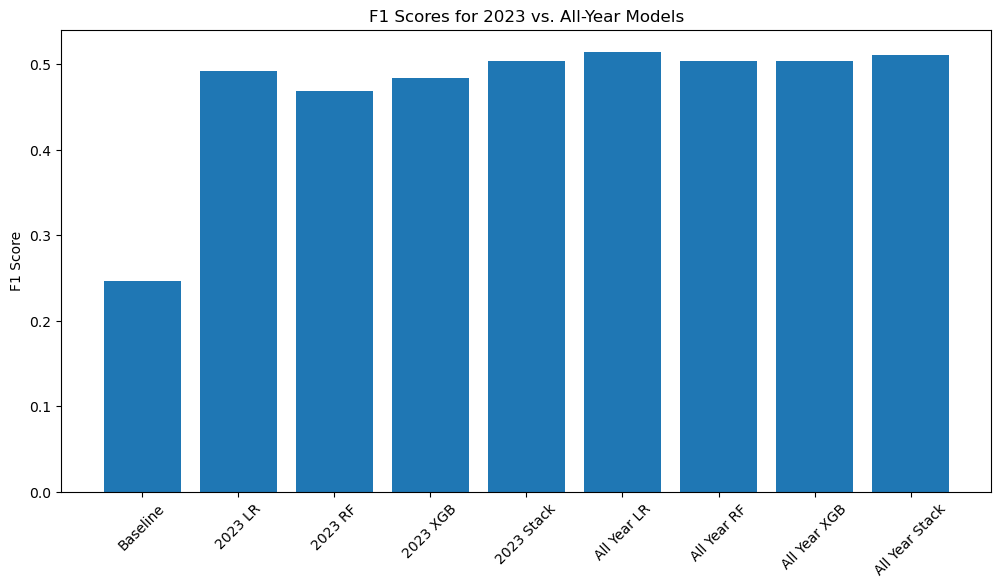

In [136]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()